<a href="https://colab.research.google.com/github/CRosero/aml-project/blob/master/train_step_4_FDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset from drive.
( You can find the zipped folder [here](https://drive.google.com/file/d/1XsRmyQYHfgRFJCOueXpJ37yyOCrKHO-W/view?usp=sharing))

In [32]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/gdrive/')
data_path = "/content/data"

use_complete_dataset = False


if (use_complete_dataset == True) and (not os.path.isfile('/content/data.zip')):
  print("download entire dataset")
  !gdown --id 1A2dBwPlCyXHTqmG1LRvPfVm6K21jWwUI # 3-5 min
  !jar xf  "/content/data.zip"
elif (use_complete_dataset == False) and (not os.path.isfile('/content/data.zip')):
  # Load cropped dataset containing only 10 images
  print("download cropped dataset")
  !gdown --id 1gPcwDJsNpyqcjKu225hnIxkURpjUA08i   
  !jar xf  "/content/data.zip"
else:
  print("dataset already downloaded")

if not os.path.isdir('/content/data'):
  print("Dataset doesn't exist")

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
dataset already downloaded


# Cloning the repository from github

In [33]:
# Clone the entire repo.
repo_path = "/content/cloned-repo"
if not os.path.isdir(repo_path):
  !git clone -l -s https://github.com/CRosero/aml-project.git cloned-repo
  %cd cloned-repo
else:
  print("Repository already cloned")
%cd /content/cloned-repo
!ls

Repository already cloned
/content/cloned-repo
dataset       legend.png  runs		      train_step_4_FDA.ipynb
demo_images   model	  scripts	      train_step_4.ipynb
FDA.ipynb     README.md   train_step_2.ipynb  utils
image_output  results	  train_step_3.ipynb


# Importing the libraries

In [34]:
!pip install torchinfo

In [35]:
!pip install -U 'git+https://github.com/facebookresearch/fvcore'

  Cloning https://github.com/facebookresearch/fvcore to /tmp/pip-req-build-324xdj_i
  Running command git clone -q https://github.com/facebookresearch/fvcore /tmp/pip-req-build-324xdj_i


In [36]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.cuda.amp as amp

import torchvision
from torchvision.transforms import InterpolationMode
from torch.utils import data
import torch.nn.functional as F


from utils.utils import reverse_one_hot, compute_global_accuracy, fast_hist, per_class_iu, colour_code_segmentation,poly_lr_scheduler
from utils.loss import CrossEntropy2d,DiceLoss
import numpy as np
import os
import os.path as osp
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from torchinfo import summary
from fvcore.nn import FlopCountAnalysis
import json
import argparse
from tqdm import tqdm

# Dataset class:
from dataset.cityscapesDataSet import cityscapesDataSet
from dataset.GTA5DataSet import GTA5DataSet
# Discriminator
from model.discriminator import FCDiscriminator, LightWeightFCDiscriminator
# Network
from model.build_BiSeNet import BiSeNet
# Validation function
from scripts.eval import val

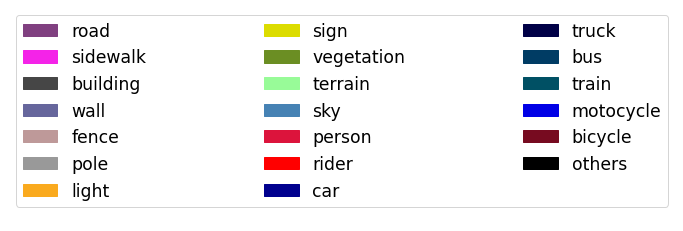

In [37]:
from matplotlib.patches import Rectangle
fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot()


palette = [[128,64,128],[244,35,232], [70,70,70],[102,102,156],[190,153,153],[153,153,153],[250,170,30],[220,220,0],[107,142,35],[152,251,152],[70,130,180],[220,20,60],[255,0,0],[0,0,142],[0,0,70],[0,60,100],[0,80,100],[0,0,230],[119,11,32],[0,0,0]]
labels = ["road","sidewalk","building","wall","fence","pole","light","sign","vegetation","terrain","sky","person","rider","car","truck","bus","train","motocycle","bicycle", "others"]
legend_data = list(zip(palette, labels))

handles = [Rectangle((0,0),10,10, color = tuple((v/255 for v in c))) for c,n in legend_data]
labels = [n for c,n in legend_data]

ax.legend(handles, labels, mode='expand', ncol=3, fontsize="xx-large")
ax.axis('off')
plt.savefig("/content/cloned-repo/legend.png")
plt.show()

In [38]:
def enable_cuda(obj, gpu):
  if torch.cuda.is_available():
    return obj.cuda(gpu)
  else:
    return obj

In [39]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [40]:
def loss_calc(pred, labels, gpu, ignore_label=255):
    """
    This function returns cross entropy loss for semantic segmentation
    """
    # out shape batch_size x channels x h x w -> batch_size x channels x h x w
    # label shape h x w x 1 x batch_size  -> batch_size x 1 x h x w
    labels = Variable(labels.long()).cuda(gpu)
    labels = enable_cuda(labels, gpu)
    criterion = CrossEntropy2d(ignore_label= ignore_label)
    criterion = enable_cuda(criterion, gpu)

    return criterion(pred, labels)


def lr_poly(base_lr, iter, max_iter, power):
    return base_lr * ((1 - float(iter) / max_iter) ** (power))


def adjust_learning_rate(args, optimizer, i_iter):
    lr = lr_poly(args.learning_rate, i_iter, args.num_steps, args.power)
    optimizer.param_groups[0]['lr'] = lr
    if len(optimizer.param_groups) > 1:
        optimizer.param_groups[1]['lr'] = lr * 10


def adjust_learning_rate_D(args, optimizer, i_iter):
    lr = lr_poly(args.learning_rate_D, i_iter, args.num_steps, args.power)
    optimizer.param_groups[0]['lr'] = lr
    if len(optimizer.param_groups) > 1:
        optimizer.param_groups[1]['lr'] = lr * 10


In [41]:
def train(args, model, model_D, optimizer,optimizer_D, sourceloader, targetloader, targetloaderVal, iter_size, miou_init=0, iter_start_i=0):
  # labels for adversarial training
  source_label_id = 0
  target_label_id = 1

  if args.gan == 'Vanilla':
    bce_loss = torch.nn.BCEWithLogitsLoss()
  elif args.gan == 'LS':
    bce_loss = torch.nn.MSELoss()

  writer = SummaryWriter()
  max_miou = miou_init
  for i_iter in range(iter_start_i, args.num_steps):

    loss_seg_value = 0
    loss_adv_target_value = 0
    loss_D_value = 0

    optimizer.zero_grad()
    adjust_learning_rate(args, optimizer, i_iter)

    optimizer_D.zero_grad()
    adjust_learning_rate_D(args, optimizer_D, i_iter)
    sourceloader_iter = enumerate(sourceloader)
    targetloader_iter = enumerate(targetloader)
    
    for sub_i in range(iter_size): 
        # train G
        model.train()

        
        # don't accumulate grads in D
        for param in model_D.parameters():
            param.requires_grad = False

        # train with source images and labels
        _, batch = next(sourceloader_iter)
        source_images, source_labels = batch
        source_images = Variable(source_images)
        source_images = enable_cuda(source_images, args.gpu)

        pred_source_result, pred_source_1, pred_source_2 = model(source_images)
        loss1 = loss_calc(pred_source_result, source_labels, args.gpu, args.ignore_label)
        loss2 = loss_calc(pred_source_1, source_labels, args.gpu, args.ignore_label)
        loss3 = loss_calc(pred_source_2, source_labels, args.gpu, args.ignore_label)
        loss_seg = loss1 + loss2 + loss3

        # proper normalization
        loss_seg = loss_seg / iter_size
        loss_seg.backward()
        #print("Segmentation loss:", loss_seg.data.cpu().numpy())
        #print(loss_seg.data.cpu().numpy().shape)
        loss_seg_value += loss_seg.data.cpu().numpy() / iter_size

        # train with target images
        _, batch = next(targetloader_iter)
        target_images, _ = batch
        target_images = Variable(target_images).cuda(args.gpu)

        pred_target_result, pred_target_1, pred_target_2 = model(target_images)

        # generator vs. discriminator 
        D_out = model_D(F.softmax(pred_target_result))

        loss_adv_target = bce_loss(D_out, Variable(torch.FloatTensor(D_out.data.size()).fill_(source_label_id)).cuda(args.gpu))
        loss = args.lambda_adv_target * loss_adv_target
        loss = loss / iter_size
        loss.backward()
        loss_adv_target_value += loss_adv_target.data.cpu().numpy() / iter_size

        # train discriminator
        # bring back requires_grad
        for param in model_D.parameters():
            param.requires_grad = True

        # train with source
        pred_source_result = pred_source_result.detach()
        
        D_out_source = model_D(F.softmax(pred_source_result))
        loss_D_source = bce_loss(D_out_source, Variable(torch.FloatTensor(D_out_source.data.size()).fill_(source_label_id)).cuda(args.gpu))
        loss_D_source = loss_D_source / iter_size / 2
        loss_D_source.backward()

        loss_D_value += loss_D_source.data.cpu().numpy()

        # train with target
        pred_target_result = pred_target_result.detach()

        D_out_target = model_D(F.softmax(pred_target_result))

        loss_D_target = bce_loss(D_out_target, Variable(torch.FloatTensor(D_out_target.data.size()).fill_(target_label_id)).cuda(args.gpu))
        loss_D_target = loss_D_target / iter_size / 2
        loss_D_target.backward()

        loss_D_value += loss_D_target.data.cpu().numpy()

    optimizer.step()
    optimizer_D.step()

    writer.add_scalar('loss_seg_value', loss_seg_value, i_iter)
    writer.add_scalar('loss_adv_target_value', loss_adv_target_value, i_iter)
    writer.add_scalar('loss_D_value', loss_D_value, i_iter)
    print('iter = {0:8d}/{1:8d}, loss_seg = {2:.3f}, loss_adv = {3:.3f}, loss_D = {4:.3f}'.format(i_iter, args.num_steps, loss_seg_value, loss_adv_target_value, loss_D_value))


    if i_iter % args.save_pred_every == 0 and i_iter != 0:
        print(" Saving checkpoint in ", args.save_models_path, "latest_CE_loss.pth")
        if not os.path.isdir(args.save_models_path):
            os.mkdir(args.save_models_path)
        torch.save({
                  'iter': i_iter,
                  'segNet_state_dict': model.state_dict(),
                  'D_state_dict': model_D.state_dict(),
                  'optimizer_seg_state_dict': optimizer.state_dict(),
                  'optimizer_D_state_dict': optimizer_D.state_dict(),
                  'max_miou' : max_miou,
                    },
                    os.path.join(args.save_models_path, 'latest_CE_loss.pth'))

    
    if i_iter % args.validation_step == 0:
        print(" doing validation at iter ", i_iter)
        precision, miou = val(args, model, targetloaderVal)
        if miou > max_miou:
            max_miou = miou
            print(" Saving checkpoint in ", args.save_models_path, "best_CE_loss.pth")
            os.makedirs(args.save_models_path, exist_ok=True)
            torch.save({
                  'iter': i_iter,
                  'segNet_state_dict': model.state_dict(),
                  'D_state_dict': model_D.state_dict(),
                  'optimizer_seg_state_dict': optimizer.state_dict(),
                  'optimizer_D_state_dict': optimizer_D.state_dict(),
                  'max_miou' : max_miou,
                    },
                    os.path.join(args.save_models_path, 'best_CE_loss.pth'))
        writer.add_scalar('precision', precision, i_iter)
        writer.add_scalar('miou', miou, i_iter)

  return

In [42]:
def get_arguments(params=[]):
    """Parse all the arguments provided from the CLI.
    Returns:
      A list of parsed arguments.
    """
        
    # basic parameters
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", type=str, default='BiseNet',
                        help="available options : BiseNet")
    parser.add_argument("--target", type=str, default='Cityscapes',
                        help="available options : Cityscapes")
    parser.add_argument("--batch-size", type=int, default=2,
                        help="Number of images sent to the network in one step.")
    parser.add_argument("--num-workers", type=int, default=4,
                        help="number of workers for multithread dataloading.")
    parser.add_argument("--data-dir", type=str, default='',
                        help="Path to the directory containing the source dataset.")
    parser.add_argument("--ignore-label", type=int, default= 255,
                        help="The index of the label to ignore during the training.")
    parser.add_argument("--input-size", type=str, default='1024,512',
                        help="Comma-separated string with height and width of source images.")
    parser.add_argument("--input-size-target", type=str, default='1024,512',
                        help="Comma-separated string with height and width of target images.")
    parser.add_argument("--is-training", action="store_true",
                        help="Whether to updates the running means and variances during the training.")
    parser.add_argument("--learning-rate", type=float, default=2.5e-2,
                        help="Base learning rate for training with polynomial decay.")
    parser.add_argument("--learning-rate-D", type=float, default=1e-4,
                        help="Base learning rate for discriminator.")
    parser.add_argument("--lambda-seg", type=float, default=1,
                        help="lambda_seg.")
    parser.add_argument("--lambda-adv-target", type=float, default=0.001,
                        help="lambda_adv for adversarial training.")
    parser.add_argument("--momentum", type=float, default=0.9,
                        help="Momentum component of the optimiser.")
    parser.add_argument("--num-classes", type=int, default=19,
                        help="Number of classes to predict (including background).")
    parser.add_argument("--num-steps", type=int, default=50,
                        help="Number of training steps.")
    parser.add_argument("--num-steps-stop", type=int, default=150,
                        help="Number of training steps for early stopping.")
    parser.add_argument("--power", type=float, default=0.9,
                        help="Decay parameter to compute the learning rate.")
    parser.add_argument("--random-mirror", action="store_true",
                        help="Whether to randomly mirror the inputs during the training.")
    parser.add_argument("--random-scale", action="store_true",
                        help="Whether to randomly scale the inputs during the training.")
    parser.add_argument("--random-seed", type=int, default=42,
                        help="Random seed to have reproducible results.")
    parser.add_argument("--save-pred-every", type=int, default=10,
                        help="Save summaries and checkpoint every often.")
    parser.add_argument("--weight-decay", type=float, default=1e-4,
                        help="Regularisation parameter for L2-loss.")
    parser.add_argument("--gpu", type=int, default=0,
                        help="choose gpu device.")
    parser.add_argument("--gan", type=str, default='Vanilla',
                        help="choose the GAN objective.")
    parser.add_argument('--context_path', type=str, default='resnet18',
                        help='The context path model you are using, resnet18, resnet101.')
    parser.add_argument('--validation_step', type=int, default=10, help='How often to perform validation (epochs)')
    parser.add_argument('--use_gpu', type=bool, default=True, help='whether to user gpu for training')
    parser.add_argument("--light_discriminator", type=bool, default=False, 
                        help="using discriminator with lightweight depthwise-separable convolutions")
    parser.add_argument('--load_pretrained_models', type=bool, default=False, help='load or not the pretrained models from the saved checkpoint ')
    parser.add_argument('--pretrained_models_path', type=str, default="", help='path to pretrained models')
    parser.add_argument('--save_models_path', type=str, default="", help='path to save models')



    args = parser.parse_args(params)
    return args

In [43]:
def main(params):
  """Create the model and start the training."""
  args = get_arguments(params)

  # Set random seed
  torch.manual_seed(args.random_seed)
  torch.cuda.manual_seed(args.random_seed)
  np.random.seed(args.random_seed)
  random.seed(args.random_seed)

  # input sizes
  w, h = map(int, args.input_size.split(','))
  input_size = (w, h)

  w, h = map(int, args.input_size_target.split(','))
  input_size_target = (w, h)

  cudnn.benchmark = True
  cudnn.enabled = True
  gpu = args.gpu

  # Create network
  if args.model == 'BiseNet':
    model = BiSeNet(num_classes=args.num_classes, context_path= args.context_path)

  # Set the network to train mode
  model.train()
  model = enable_cuda(model, args.gpu)

  # init D
  if args.light_discriminator == False:
    print("Using a fully convolutional discriminator")
    model_D = FCDiscriminator(num_classes=args.num_classes)
  else:
    print("Using a discriminator with lightweight depthwise-separable convolution")
    model_D = LightWeightFCDiscriminator(num_classes=args.num_classes)

  # Set the discriminators to train mode
  model_D.train()
  model_D = enable_cuda(model_D, args.gpu)

  
  ''' 
  # Printing statistics
  print("Segmentation Network\n")
  print(summary(enable_cuda(model.eval(), args.gpu), input_size=(BATCH_SIZE, 3, input_size[0], input_size[1])))

  if args.light_discriminator == False: 
    print("Adversarial discriminator Architecture\n")
  else:
    print("Lightweight Adversarial Domain Adaptation\n")
  print(summary(enable_cuda(model_D.eval(), args.gpu), input_size=(BATCH_SIZE, 19, input_size[0], input_size[1])))
  '''
  # Path
  source_data_root_path = os.path.join(args.data_dir, "GTA5") # /content/data/GTA5
  target_data_root_path = os.path.join(args.data_dir, args.target) # /content/data/Cityscapes
  source_train_path = os.path.join(source_data_root_path, "train.txt") # /content/data/GTA5/train.txt
  target_root_path = os.path.join(target_data_root_path,  "train.txt")   # /content/data/Cityscapes/train.txt
  info_path = os.path.join(source_data_root_path,  "info.json") # /content/data/GTA/info.json 

  info_json = json.load(open(info_path))

  # Image mean
  IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)

  # Datasets  
  source_dataset = GTA5DataSet(source_data_root_path, source_train_path, info_json, crop_size=input_size, scale=args.random_scale, mirror=args.random_mirror, mean=IMG_MEAN)
  target_dataset = cityscapesDataSet(target_data_root_path, target_root_path, info_json, crop_size=input_size_target, scale=False, mirror=args.random_mirror, mean=IMG_MEAN)

  print("GTA: ", len(source_dataset))
  print("Cityscapes: ", len(source_dataset))
  img,label = source_dataset[0]
  print ("GTA image", img.shape )
  print ("GTA label", label.shape )
  img, _ = target_dataset[0]
  print ("Cityscapes image", img.shape )

  # Itersize
  assert len(source_dataset)==len(target_dataset)
  iter_size = len(source_dataset) // args.batch_size # the source and the target have the same len
  print("Iter_Size = ", iter_size)

  # Create DataLoaders
  sourceloader = data.DataLoader(source_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)
  targetloader = data.DataLoader(target_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)
  targetloaderVal = data.DataLoader(target_dataset, batch_size=1, shuffle=True, num_workers=args.num_workers, pin_memory=True)

  # Optimizer

  optimizer = optim.SGD(model.parameters(), lr=args.learning_rate, momentum=args.momentum, weight_decay=args.weight_decay)
  optimizer.zero_grad()

  optimizer_D = optim.Adam(model_D.parameters(), lr=args.learning_rate_D, betas=(0.9, 0.99))
  optimizer_D.zero_grad()

  # to keep track of best miou
  max_miou = 0
  # start iteration from:
  iter_start_i = 0

  # load pretrained model if exists
  checkpoint = None
  if (args.load_pretrained_models) and (args.pretrained_models_path is not None) and (os.path.isfile(args.pretrained_models_path)):
      print('load models from %s ...' % args.pretrained_models_path)
      checkpoint= torch.load(args.pretrained_models_path)
      model.load_state_dict(checkpoint['segNet_state_dict'])
      model_D.load_state_dict(checkpoint['D_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_seg_state_dict'])
      optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
      iter_start_i = int(checkpoint['iter'])+1
      max_miou = float(checkpoint['max_miou']) 
      print('Done! Loaded model trained until iter:', iter_start_i, "best miou so far:", max_miou)

  # train
  train(args, model, model_D, optimizer,optimizer_D, sourceloader, targetloader, targetloaderVal,iter_size, miou_init=max_miou, iter_start_i=iter_start_i)
  # final val
  val(args, model, targetloaderVal, save=True)

In [44]:

if __name__ == '__main__':
    params = [
              '--model', 'BiseNet',
              '--target', 'Cityscapes',
              '--batch-size', '2',
              '--num-workers', '4',
              '--data-dir', '/content/data/',
              '--ignore-label', '255',
              '--input-size', '1024,512',
              '--input-size-target',  '1024,512',
              '--learning-rate', '2.5e-2',
              '--learning-rate-D', '1e-4',
              '--lambda-seg', '1',
              '--lambda-adv-target', '0.001',
              '--momentum', '0.9',
              '--power', '0.9',
              '--weight-decay','1e-4',
              '--num-classes', '19',
              '--num-steps', '50', # number of iteration over the whole dataset
              '--gpu', '0',
              '--gan', 'Vanilla',
              '--context_path', 'resnet18', # or 'resnet101'
              '--save-pred-every', '2',
              '--validation_step', '2',
              '--light_discriminator', False,
              '--load_pretrained_models', False,
              '--pretrained_models_path','/gdrive/MyDrive/Project_AML/Models/checkpoints_segNet/latest_CE_loss.pth',
              '--save_models_path', '/gdrive/MyDrive/Project_AML/Models/checkpoints_segNet/' 


    ]
    main(params)


GTA:  10
Cityscapes:  10
GTA image (3, 512, 1024)
GTA label (512, 1024)
Cityscapes image (3, 512, 1024)
Iter_Size =  5
iter =        0/      50, loss_seg = 2.084, loss_adv = 0.695, loss_D = 0.693
 doing validation at iter  0


val: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


precision per pixel for test: 0.016
mIoU for validation: 0.005
 Saving checkpoint in  /gdrive/MyDrive/Project_AML/Models/checkpoints_segNet/ best_CE_loss.pth


KeyboardInterrupt: ignored